In [ ]:
# Import libraries
import torch
from torch import tensor
from torch import nn 
from torch import sigmoid
from torch import atan
from torch import tanh
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

seed = 7777
random.seed(seed) 
torch.manual_seed(seed)

In [ ]:
lpy_min = 50 #mm
lpy_max = 2050 #mm
lpx_min = 50 #mm
lpx_max = 650 #mm
wp_min = 25 # mm
wp_max = 325 # mm
a_min = 0 # mm
a_max = 200 # mm
p_min = 0 # mm
p_max = 200 # mm
ls_min = 50 # mm
ls_max = 450 # mm
ws_min = 25 # mm
ws_max = 225 # mm
# Ip_min = 50 # A rms
# Ip_max = 200 # A rms
# Np_min = 4 #turn
# Np_max = 10 #turn
# Ns_min = 4 #turn
# Ns_max = 10 #turn

In [ ]:
class Model(nn.Module): # Design your model using class
    def __init__(self):    
        super(Model, self).__init__() #In the constructor, we instantiate nn.Linear module.
        self.linear1 = nn.Linear(12, 100, bias=True).cuda() # nn.Linear(<input size> ,<output size>)
        self.linear2 = nn.Linear(100, 100, bias=True).cuda()
        self.linear3 = nn.Linear(100, 42, bias=True).cuda()

    def forward(self, x):
        x = atan(self.linear1(x))
        x = atan(self.linear2(x))
        x = atan(self.linear2(x))
        y_pred = self.linear3(x)
        return y_pred

In [ ]:
model = Model() # our model
model.load_state_dict(torch.load('saved_model_state.pt'))

for param in model.parameters():
    param.requires_grad = False

In [ ]:
def generate_noise(a, b):
    low,high = -1, 1  # range of uniform distribution

    return torch.distributions.uniform.Uniform(low,high).sample([a,b]).cuda()

In [ ]:
from torch.nn.modules import activation

class Generator(nn.Module):

    def __init__(self, input_length: int): 
      super(Generator, self).__init__() 
      self.dense_layer = nn.Linear(int(input_length), 128).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer.weight) 
      self.dense_layer1 = nn.Linear(128, 256).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer1.weight) 
      self.dense_layer2 = nn.Linear(256, 512).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer2.weight) 
      self.dense_layer3 = nn.Linear(512, 256).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer3.weight) 
      self.dense_layer4 = nn.Linear(256, 128).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer4.weight) 
      self.dense_layer5 = nn.Linear(128, int(input_length)).cuda() 
      torch.nn.init.kaiming_uniform_(self.dense_layer5.weight) 
      self.activation = nn.Sigmoid() 

    def forward(self, x): 
      x = atan(self.dense_layer(x)) 
      x = atan(self.dense_layer1(x)) 
      x = atan(self.dense_layer2(x)) 
      x = atan(self.dense_layer3(x)) 
      x = atan(self.dense_layer4(x)) 
      x = self.activation(self.dense_layer5(x)) 
      return x 

In [ ]:
generator = Generator(7)
for param in generator.parameters():
    param.requires_grad = True

In [ ]:
def scaler(value, min , max):
    return value * (max - min) + min

In [ ]:
@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    """
    Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
    Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.
    """
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)
    
    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)
    
    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps*(stop - start)[None]
    
    return out

In [ ]:
def scale_and_extract(arr):
    scaler_min = torch.tensor([50., 50., 25., 0., 0., 50., 25.], requires_grad=True, device="cuda")
    scaler_max = torch.tensor([2050., 650., 325., 200., 200., 450., 225.], requires_grad=True, device="cuda")
    arr = scaler(arr, scaler_min, scaler_max)
    y0_i = (arr[:,0] + arr[:,2]) / 2
    y1_i = (3/2 * arr[:,0]) + (5/2 * arr[:,2]) + (2 * arr[:,3]) + (arr[:,4])

    ys_min = (y1_i)
    ys_max = (y1_i + (y1_i - y0_i) / 2)
    
    ys = linspace(ys_min, ys_max, num = 5)
    ys = torch.transpose(ys, 0, 1)

    return torch.cat([arr, ys], axis=1)


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
TRAINING = 10001
learning_rate = 1e-3
optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

#optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate)

In [ ]:
kdiffs = []

In [ ]:
noise = generate_noise(1000, 7)
GP = generator(noise)
print(noise[100],noise[101],noise[102])
print(GP[100],GP[101],GP[102])
scaled_array = scale_and_extract(GP)

MP = model(scaled_array)
print(MP[100],MP[101],MP[102])

tensor([-0.8936, -0.2138, -0.4511,  0.8787, -0.7498, -0.7834, -0.3224],
       device='cuda:0') tensor([ 0.5917,  0.1660, -0.1943,  0.9169,  0.3506, -0.6533,  0.9419],
       device='cuda:0') tensor([ 0.4798, -0.2450,  0.8223, -0.9302, -0.1878, -0.8974,  0.7301],
       device='cuda:0')
tensor([0.4250, 0.2418, 0.4831, 0.2738, 0.7462, 0.2538, 0.2466],
       device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5039, 0.6671, 0.6090, 0.7169, 0.5654, 0.5274, 0.1623],
       device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4466, 0.4244, 0.7312, 0.7686, 0.2283, 0.5829, 0.7822],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 2.2739e-01,  1.2070e-01, -3.7079e-01, -3.6483e-01,  3.7322e-02,
         3.3239e-01,  9.5422e-01,  9.4154e-01,  9.4342e-01,  1.1591e+00,
         8.5877e-01,  1.1863e+00,  1.2562e+00,  8.5783e-01,  1.2282e+00,
         1.2639e+00,  9.4228e-01,  1.0589e+00,  2.2289e-01,  4.8394e-01,
        -6.9817e-01, -9.1345e-01,  1.4945e+00, -8.4713e-01,  7.1631e-01,

In [ ]:
for i in range(TRAINING):
    
    # zero out the parameter gradients
    # self.optimizer.zero_grad() is slow
    # for param in generator.parameters():
    #     param.grad = None
    optimizer.zero_grad()

    noise = generate_noise(100, 7) #IP, Ns and Np
    GP = generator(noise)
    scaled_array = scale_and_extract(GP)

    MP = model(scaled_array)
    #print(MP[0], GP[0])
    #calculate Is 
    kdiff = MP[:, 0] - MP[:, 5]
    kdiff = abs(kdiff / MP[:, 0])
    kdiff = torch.mean(kdiff) # + scaling factor * Bstray Loss 
    kdiffs.append(kdiff.detach().cpu().item())
    kdiff.backward()

    #First consider only Bstray 
    optimizer.step()

    if i % 2500 == 0:
        print(f"Epoch: {i:4d} | Coupling: {100 * kdiff:.3f}%")


Epoch:    0 | Coupling: 77.062%
Epoch: 2500 | Coupling: 5.750%
Epoch: 5000 | Coupling: 3.293%
Epoch: 7500 | Coupling: 3.116%
Epoch: 10000 | Coupling: 6.164%


In [ ]:
with torch.no_grad():
  noise = generate_noise(10000, 7)
  GP = generator(noise)
  scaled_array = scale_and_extract(GP)
  MP = model(scaled_array)
  print(noise[0], noise[9000])
  print(GP[0], GP[9000])
  print(MP[1], MP[9000])

tensor([ 0.4034, -0.9187,  0.3704,  0.8084, -0.4657, -0.3782,  0.9670],
       device='cuda:0') tensor([-0.6369,  0.6334, -0.4211,  0.2497, -0.4581,  0.8631, -0.2245],
       device='cuda:0')
tensor([3.3226e-10, 6.5962e-01, 3.2370e-07, 1.3842e-01, 7.5380e-03, 1.0000e+00,
        9.9367e-01], device='cuda:0') tensor([1.0000e+00, 7.8074e-01, 1.0000e+00, 1.4176e-01, 1.1241e-01, 4.0638e-05,
        5.3372e-01], device='cuda:0')
tensor([ 0.7392,  0.8141,  0.6203,  0.6055, -0.9572,  0.7297,  0.3146,  0.3644,
         0.2664,  0.4437,  0.3543,  0.4566,  0.3178,  0.5277,  0.4811,  0.3324,
         0.2196,  0.5176, -1.2785,  0.0249, -0.6112, -0.2713,  0.8598, -0.4000,
         0.7951,  0.6460,  0.3960, -0.1254,  0.1691,  0.7482, -1.3016,  0.3591,
        -0.6893,  1.5053,  0.3125,  0.9177,  1.2763,  0.4355,  0.5492,  0.7620,
         0.5029,  0.5138], device='cuda:0') tensor([ 3.0000e-01,  1.9459e-01, -4.3931e-01, -5.0511e-01, -1.0212e-01,
         3.2598e-01,  1.0676e+00,  1.0354e+00,  1.0113e

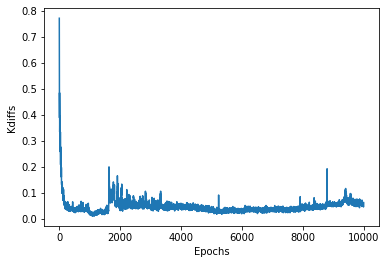

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel('Kdiffs')
plt.plot(kdiffs)
